# Group 16: Project 2


## EDA

#### Reading in Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

test = pd.read_csv('./data/testing_data.csv')
train = pd.read_csv('./data/training_data.csv')

# Dropping row number and 'id' columns
test = test.drop(columns=['Unnamed: 0','id'])
train = train.drop(columns=['Unnamed: 0','id'])

# Renaming residence_type to make capitalization uniform
test = test.rename(columns={'Residence_type':'residence_type'})
train = train.rename(columns={'Residence_type':'residence_type'})

In [2]:
train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,36.0,0,0,Yes,Govt_job,Urban,65.87,32.2,formerly smoked,0
1,Female,45.0,0,0,Yes,Govt_job,Rural,68.66,25.3,never smoked,0
2,Male,58.0,0,0,No,Self-employed,Rural,170.93,30.7,Unknown,0
3,Female,61.0,0,0,Yes,Self-employed,Urban,69.88,27.1,never smoked,0
4,Female,78.0,0,0,No,Private,Urban,103.86,30.6,Unknown,0


In [3]:
# Finding NaNs in train, test
print(train.isna().sum().sum())
print(test.isna().sum().sum())

# Dropping NaNs, all of which occur in bmi
train['bmi'] = train['bmi'].fillna(train['bmi'].mean())
test['bmi'] = test['bmi'].fillna(test['bmi'].mean())

print(train.isna().sum().sum())
print(test.isna().sum().sum())

159
42
0
0


Rows for NaN values in bmi are imputed with the mean. As seen later, bmi is not strongly correlated with stroke, so making the assumption that the missing bmi's are average likely won't negatively affect model performance (as bmi likely won't be the most influential variable). Though the rows are not dropped, as they could hold other data which are important

#### Summary Data

Numeric variables: age, hypertension, heart_disease, avg_glucose_level, bmi

Categorical variables: gender, ever_married, work_type, residence_type, smoking_status

In [4]:
numerics = ['age','hypertension','heart_disease','avg_glucose_level','bmi','stroke']
cats = ['gender','ever_married','work_type','residence_type','smoking_status'] # cats!

(train[numerics]).describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000
mean,43.324169,0.097871,0.056031,106.010396,28.923371,0.048691
std,22.531019,0.297177,0.230010,45.047912,7.688969,0.215248
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,26.000000,0.000000,0.000000,77.295000,23.900000,0.000000
50%,45.000000,0.000000,0.000000,92.000000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,113.845000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


#### Density plots of Numeric Variables

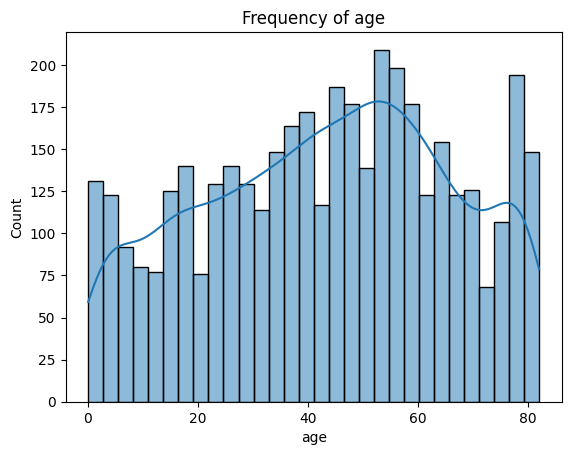

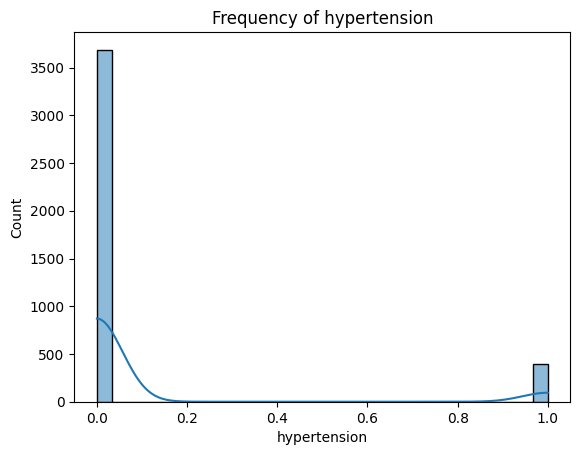

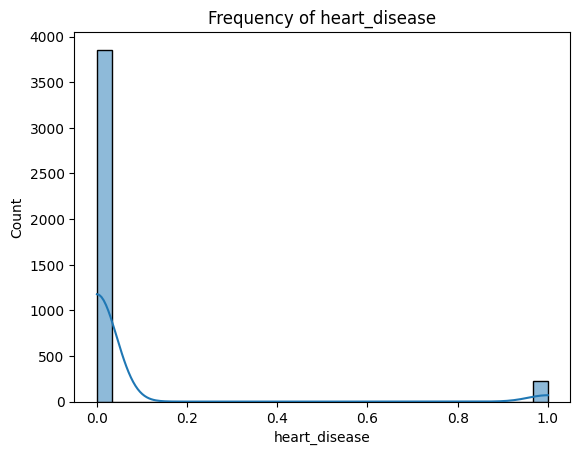

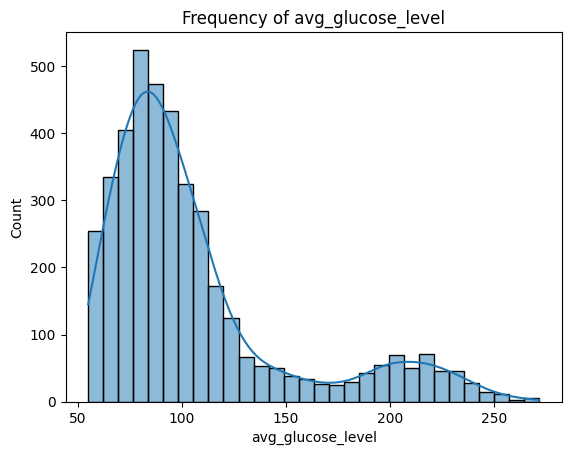

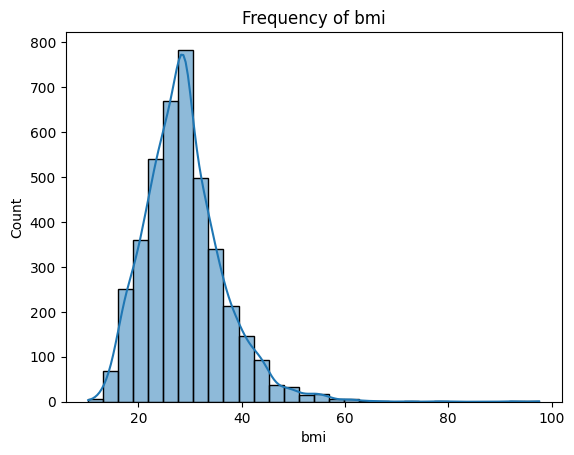

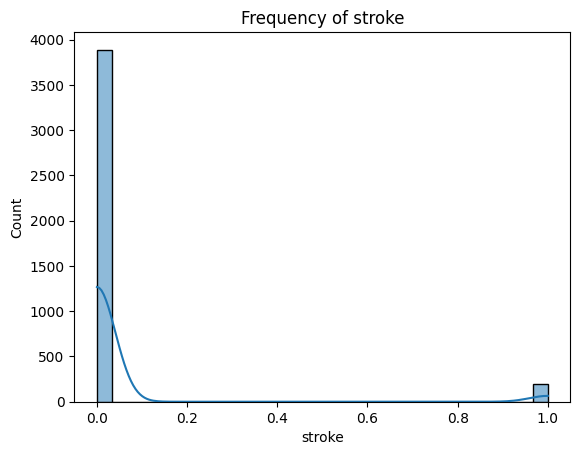

In [5]:
for var in numerics:
    sns.histplot(train[var],kde=True,bins=30)
    plt.title(f'Frequency of {var}')
    plt.show()

#### Bar Charts of Categorical Variables

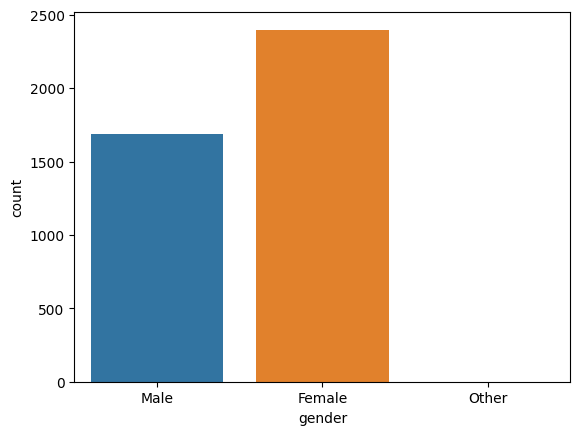

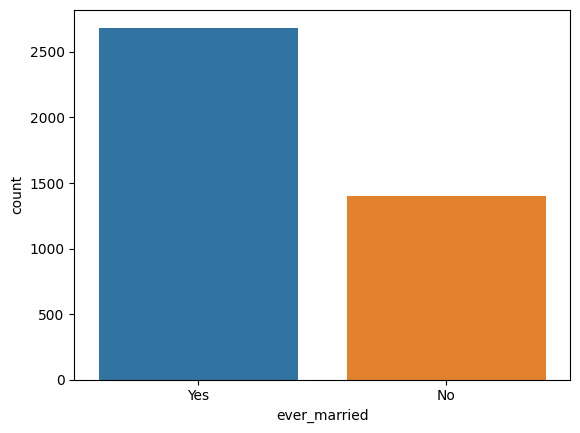

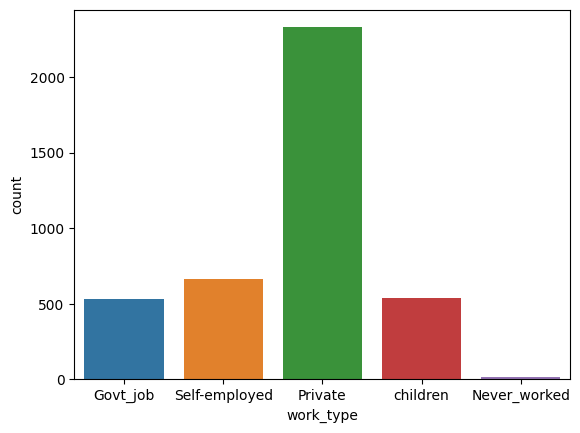

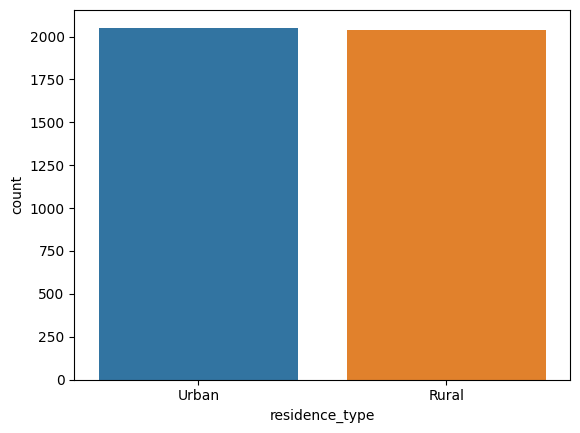

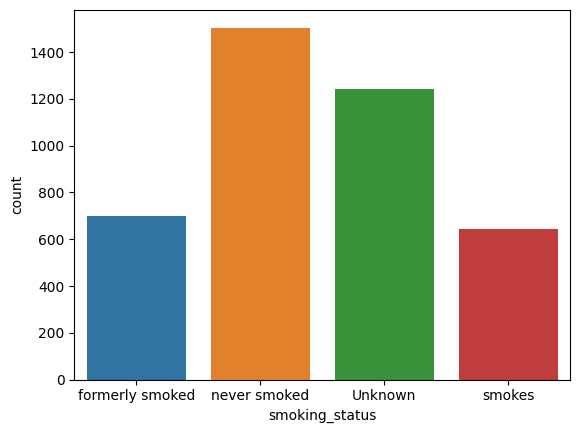

In [6]:
for var in cats:
    sns.countplot(x=var,data=train)
    plt.show()

#### Correlation Matrix of Numeric Variables

Text(0.5, 1.0, 'Correlation Matrix of Numeric Variables')

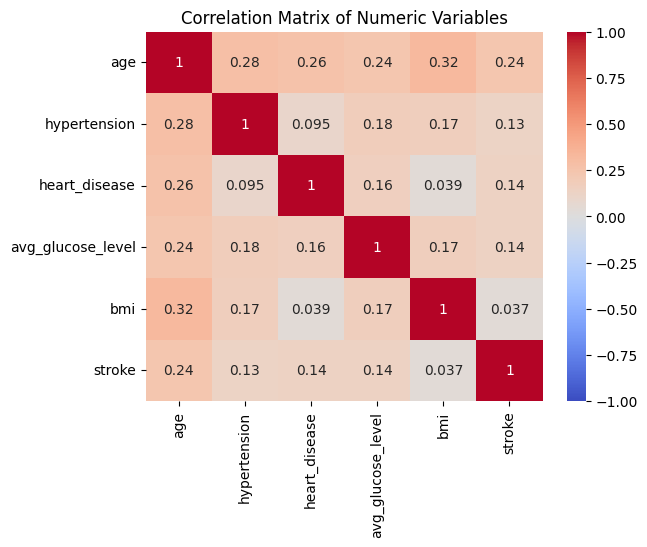

In [7]:
corr_matrix = train[numerics].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numeric Variables")

#### One-hot Encoding of Categoricals

In [8]:
train_cats = pd.get_dummies(train[cats])
train_cats['stroke'] = train['stroke']

#### Correlations of Categoricals

In [9]:
corr_matrix = train_cats.corr()
corr_matrix['stroke']

gender_Female                    -0.010992
gender_Male                       0.011105
gender_Other                     -0.003539
ever_married_No                  -0.098721
ever_married_Yes                  0.098721
work_type_Govt_job                0.006743
work_type_Never_worked           -0.013731
work_type_Private                 0.012856
work_type_Self-employed           0.053908
work_type_children               -0.081758
residence_type_Rural             -0.011565
residence_type_Urban              0.011565
smoking_status_Unknown           -0.057916
smoking_status_formerly smoked    0.060280
smoking_status_never smoked      -0.005374
smoking_status_smokes             0.017935
stroke                            1.000000
Name: stroke, dtype: float64

#### Feature Scaling

Function for normalizing the data, consideration of log/arcsing scaling in context of the variables, and polynomial features for numerical data

<Axes: xlabel='log_glucose', ylabel='Density'>

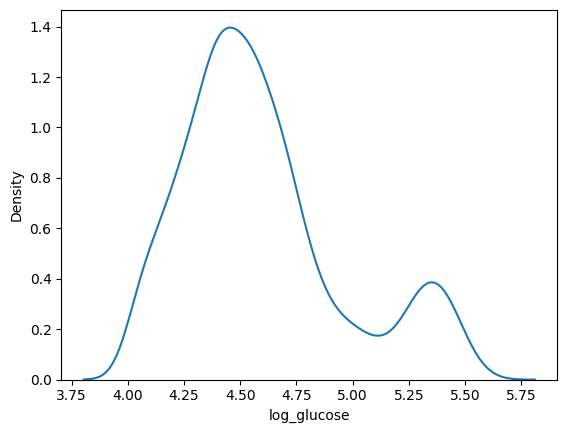

In [10]:
# Function to normalize data
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Of all the variables, the one with the most interesting potential for log is glucose level
train['log_glucose'] = np.log(train['avg_glucose_level'])
sns.kdeplot(data=train,x='log_glucose')

#### Variable Selection for Models

This section gives general ideas about feature selections, as well as a 'most general' version of the dataset (numeric features are normalized, log scaled variables and their original counterpart are included, as well as polynomial expansion of numeric variables, and one-hot encoding)

For variable selection, the following variables are the most promising for predicting stroke:
1. age - correlates most strongly with stroke
2. hypertension - decent correlation with stroke, though also correlates with age and could be redundant because of this
3. heart disease - decent correlation with stroke, but only a small proportion of the dataset have heart disease
4. glucose / log glucose - correlates somewhat with stroke, it is continuous numeric, so could have more say in classification, and the performance of the model with or without log scaled glucose could be interesting
5. ever married - the two answers to this question have opposite correlations, which could make it a powerful predictor.
6. work type - particulary in self-employed, or stay at home cases, there is correlation
7. smoking status - those who have smoked or do smoke have positive correlation with stroke
Others:
1. bmi - BMI does not strongly correlate with stroke, though since it is continous, it could be useful for providing more information than the strictly 1-0 other variables.
2. gender - gender doesn't really have any strong correlations, and is fairly evenly split.
3. residence_type - also evenly split, and doesn't seem to correlate with stroke.

Some combination, though likely not all 7, of these variables may be able to predict stroke well. One combination I think could work well (source: it came to me in a dream) is age, glucose OR log_glocuse, ever married, smoking status, and maybe 1 other variable

## Linear Models

In [11]:
# Most general dataset with all features
from sklearn.preprocessing import PolynomialFeatures

numerics = ['age','hypertension','heart_disease','avg_glucose_level','bmi']
cats = ['gender','ever_married','work_type','residence_type','smoking_status'] # cats!

ytest = test['stroke']
ytrain = train['stroke']

test = test.drop(columns='stroke')
train = train.drop(columns='stroke')

# Get dummies for categoricals
train_cats = pd.get_dummies(train[cats])
test_cats = pd.get_dummies(test[cats])


# Polynomial features
def polyfeatures(data):
    expander = PolynomialFeatures(degree=3,include_bias=False) # Create the expander
    Z = expander.fit_transform(data[numerics]) # Pass the df into the expander to get powers/interactions of x and y
    names = expander.get_feature_names_out() # Get the names of these variables
    zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
    return names, zdf

# To access 
trainPolyNames, trainPoly = polyfeatures(train)
testPolyNames, testPoly = polyfeatures(test)

# Log scaling
train['log_glucose'] = np.log(train['avg_glucose_level'])
test['log_glucose'] = np.log(test['avg_glucose_level'])

In [12]:
#poly names
poly_names = ['age^2', 'age hypertension', 'age heart_disease', 'age avg_glucose_level', 'age bmi', 'hypertension^2','hypertension heart_disease', 'hypertension avg_glucose_level','hypertension bmi', 'heart_disease^2','heart_disease avg_glucose_level', 'heart_disease bmi','avg_glucose_level^2', 'avg_glucose_level bmi', 'bmi^2']
numerics = ['age','hypertension','heart_disease','avg_glucose_level', 'bmi']

# Combining data to be exported
Xtest = test
Xtest = Xtest[numerics].apply(maxmin)
Xtest = pd.concat([Xtest, test['log_glucose'], test_cats, ytest],axis=1)
Xtest_3 = pd.concat([Xtest, test['log_glucose'], test_cats, testPoly[poly_names], ytest],axis=1)

Xtrain = train
Xtrain = Xtrain[numerics].apply(maxmin)
Xtrain = pd.concat([Xtrain, train['log_glucose'], train_cats, ytrain],axis=1)
Xtrain_3 = pd.concat([Xtrain, train['log_glucose'], train_cats, trainPoly[poly_names], ytrain],axis=1)

#make column number consistent
Xtest['gender_Other'] = 0
col = Xtest.pop('gender_Other')
Xtest.insert(8, 'gender_Other', col)


In [13]:
Xtest.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,log_glucose,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,0.706745,1.0,0.0,0.157026,0.519700,4.476882,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
1,0.095797,0.0,0.0,0.267102,0.114447,4.708539,1,0,0,1,...,1,0,0,0,1,1,0,0,0,0
2,0.853372,0.0,0.0,0.066199,0.457786,4.234686,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0
3,0.572336,0.0,0.0,0.747444,0.724203,5.351621,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0
4,0.902248,1.0,0.0,0.722913,0.808630,5.327099,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0


In [14]:
Xtrain.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,log_glucose,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,0.438477,0.0,0.0,0.049626,0.250859,4.187683,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0.548340,0.0,0.0,0.062506,0.171821,4.229167,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.707031,0.0,0.0,0.534623,0.233677,5.141254,0,1,0,1,...,0,1,0,1,0,1,0,0,0,0
3,0.743652,0.0,0.0,0.068138,0.192440,4.246779,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0.951172,0.0,0.0,0.225002,0.232532,4.643044,1,0,0,1,...,1,0,0,0,1,1,0,0,0,0


From here, polynomial features can easily be added and variables can be manipulated. Note that currently both log glucose and glucose are present, that the numeric features have been scaled, and that dummy variables are included

In [15]:
trainPoly.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'age^2', 'age hypertension', 'age heart_disease',
       'age avg_glucose_level', 'age bmi', 'hypertension^2',
       'hypertension heart_disease', 'hypertension avg_glucose_level',
       'hypertension bmi', 'heart_disease^2',
       'heart_disease avg_glucose_level', 'heart_disease bmi',
       'avg_glucose_level^2', 'avg_glucose_level bmi', 'bmi^2', 'age^3',
       'age^2 hypertension', 'age^2 heart_disease', 'age^2 avg_glucose_level',
       'age^2 bmi', 'age hypertension^2', 'age hypertension heart_disease',
       'age hypertension avg_glucose_level', 'age hypertension bmi',
       'age heart_disease^2', 'age heart_disease avg_glucose_level',
       'age heart_disease bmi', 'age avg_glucose_level^2',
       'age avg_glucose_level bmi', 'age bmi^2', 'hypertension^3',
       'hypertension^2 heart_disease', 'hypertension^2 avg_glucose_level',
       'hypertension^2 bmi', 'hypertension heart_disease^2',

Examining the data through building Linear Models

Loading in data and seperating it

In [16]:
#loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#loading the cleaned data from the data cleaning file, Project2EDA.ipynb
test = pd.read_csv('./cleaned_data/c_test.csv')
train = pd.read_csv('./cleaned_data/c_train.csv')

#loading data to get unporcessed numerics
df_train = pd.read_csv('./data/training_data.csv')
df_test = pd.read_csv('./data/testing_data.csv')

# Dropping row number and 'id' columns
x_test_r = df_test.drop(columns=['Unnamed: 0','id'])
x_train_r = df_train.drop(columns=['Unnamed: 0','id'])

# Renaming residence_type to make capitalization uniform
x_test_r = x_test_r.rename(columns={'Residence_type':'residence_type'})
x_train_r = x_train_r.rename(columns={'Residence_type':'residence_type'})

# Dropping NaNs, all of which occur in bmi
x_train_r['bmi'] = x_train_r['bmi'].fillna(x_train_r['bmi'].mean())
x_test_r['bmi'] = x_test_r['bmi'].fillna(x_test_r['bmi'].mean())

Xtrain_num_r = x_train_r.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
Xtest_num_r = x_test_r.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]

print(test.shape)
print(train.shape)

# Dropping row number
test = test.drop(columns=['Unnamed: 0'])
train = train.drop(columns=['Unnamed: 0'])

print(test.shape)
print(train.shape)

print(test.shape)
print(train.shape)

#seperate into X and y
ytest = test['stroke']
ytrain = train['stroke']
Xtest = test.drop(columns='stroke')
Xtrain = train.drop(columns='stroke')

(1023, 39)
(4087, 39)
(1023, 38)
(4087, 38)
(1023, 38)
(4087, 38)


In [17]:
#establish some column groups
poly = ['age^2', 'age hypertension', 'age heart_disease', 'age avg_glucose_level', 'age bmi', 'hypertension^2','hypertension heart_disease', 'hypertension avg_glucose_level','hypertension bmi', 'heart_disease^2','heart_disease avg_glucose_level', 'heart_disease bmi','avg_glucose_level^2', 'avg_glucose_level bmi', 'bmi^2']
numerics = ['age','hypertension','heart_disease','avg_glucose_level', 'bmi']
cats = ['gender_Female', 'gender_Male', 'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'residence_type_Rural', 'residence_type_Urban','smoking_status_Unknown', 'smoking_status_formerly smoked','smoking_status_never smoked', 'smoking_status_smokes']

In [18]:
print(Xtest_num_r.shape)
print(Xtrain_num_r.shape)

print(len(ytest))
print(len(ytrain))

(1023, 5)
(4087, 5)
1023
4087


Dateframe key

Scaled and Expanded:
- Xtest
- Xtrain

Unscaled Numerics
- Xtest_num_r
- Xtrain_num_r

Stroke Var
- ytest
- ytrain

Begin looking at Linear model for high correlation variables and combinations of them (excerpt from EDA document)
1. age - correlates most strongly with stroke
2. hypertension - decent correlation with stroke, though also correlates with age and could be redundant because of this
3. heart disease - decent correlation with stroke, but only a small proportion of the dataset have heart disease
4. glucose / log glucose - correlates somewhat with stroke, it is continuous numeric, so could have more say in classification, and the performance of the model with or without log scaled glucose could be interesting
5. ever married - the two answers to this question have opposite correlations, which could make it a powerful predictor.
6. work type - particulary in self-employed, or stay at home cases, there is correlation
7. smoking status - those who have smoked or do smoke have positive correlation with stroke

Note that for smoking status, it was made a binary value, where it was true if the subject was a current or former smoker

Below are the reusable functions made for linear regression

R2:  0.06755094279891583
RMSE:  0.20819885927632586

R2:  0.024092058215332557
RMSE:  0.21299539534087603

R2:  0.06686427646456372
RMSE:  0.2082755051993214

R2:  0.07451874494651445
RMSE:  0.20741950907055437

R2:  0.06038951880183674
RMSE:  0.20899683769127592



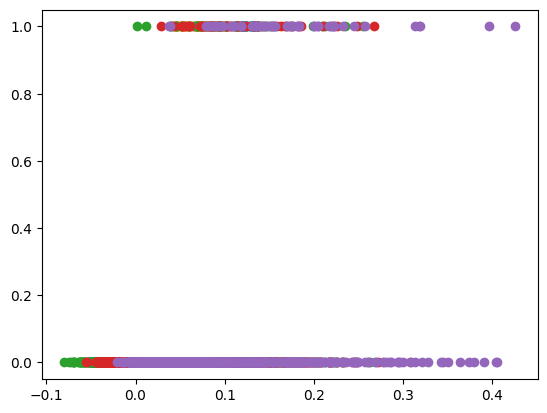

In [19]:
#create function to make models
from sklearn.linear_model import LinearRegression # Import linear regression model

def linear_reg_model(X_train, y_train, X_test, y_test):
    N_test = len(y_test)
    reg = LinearRegression().fit(X_train, y_train)
    r2 = reg.score(X_test, y_test)
    y_hat = reg.predict(X_test)
    residuals = y_test - y_hat
    #SSE = np.sum(np.square(y_hat - y_test))
    SSE = np.sum(np.square(y_test - y_hat))
    RMSE = (SSE/N_test)**(1/2)
    return r2, y_hat, residuals, SSE, RMSE
    
def showResults(r2, RMSE, y_hat, y_test):
    print("R2: ", r2)
    print("RMSE: ", RMSE)
    print(plt.scatter(y_hat, y_test), "\n")

#base line without a strategy
train_age = Xtrain['age']
test_age = Xtest['age']
r2, yhat, residuals, SSE, RMSE = linear_reg_model(train_age.values.reshape(-1,1), ytrain, test_age.values.reshape(-1,1), ytest)
showResults(r2, RMSE, yhat, ytest)

r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain[cats], ytrain, Xtest[cats], ytest)
showResults(r2, RMSE, yhat, ytest)

r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain[numerics], ytrain, Xtest[numerics], ytest)
showResults(r2, RMSE, yhat, ytest)

r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain_num_r, ytrain, Xtest_num_r, ytest)
showResults(r2, RMSE, yhat, ytest)

r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain, ytrain, Xtest, ytest)
showResults(r2, RMSE, yhat, ytest)

Strategy Number One

Use linear regression to look at different combinations of variables of interest.

In [20]:
#making smoked var
Xtest['smoked'] = Xtest['smoking_status_formerly smoked'] + Xtest['smoking_status_smokes']
Xtrain['smoked'] = Xtrain['smoking_status_formerly smoked'] + Xtrain['smoking_status_smokes']

poly_strat1 = ['age^2', 'age hypertension', 'age heart_disease', 'age avg_glucose_level', 'hypertension^2','hypertension heart_disease', 'hypertension avg_glucose_level', 'heart_disease^2','heart_disease avg_glucose_level', 'avg_glucose_level^2']
numerics_strat1 = ['age','hypertension','heart_disease','avg_glucose_level']
cats_strat1 = ['ever_married_Yes', 'work_type_Self-employed', 'work_type_children', 'smoked']
num_poly_strat1 =  ['age','hypertension','heart_disease','avg_glucose_level', 'age^2', 'age hypertension', 'age heart_disease', 'age avg_glucose_level', 'hypertension^2','hypertension heart_disease', 'hypertension avg_glucose_level', 'heart_disease^2','heart_disease avg_glucose_level', 'avg_glucose_level^2']
interactions_strat1 = ['age hypertension', 'age heart_disease', 'age avg_glucose_level', 'hypertension heart_disease', 'hypertension avg_glucose_level', 'heart_disease avg_glucose_level']
num_cat = ['age','hypertension','heart_disease','avg_glucose_level', 'ever_married_Yes', 'work_type_Self-employed', 'work_type_children', 'smoked']

Scaled Numerics
R2:  0.07243881347223613
RMSE:  0.2076524561140286

Unscaled Numerics
R2:  0.07254683364611081
RMSE:  0.20764036456264337

Scaled Numerics and Polynomials
R2:  0.08710860447868152
RMSE:  0.2060038540083217

Unscaled Numerics and Polynomials
R2:  0.08704793497696273
RMSE:  0.20601069926044618

Categoricals
R2:  0.021831399382570837
RMSE:  0.21324195107283636



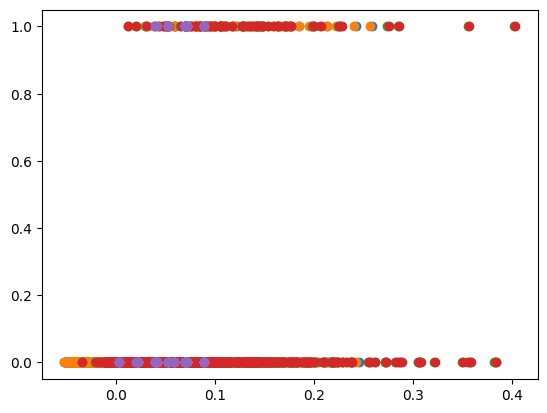

In [21]:
#testing with both scaled and non-scaled vars

#look at just the selected numerics
r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain[numerics_strat1], ytrain, Xtest[numerics_strat1], ytest)
print("Scaled Numerics")
showResults(r2, RMSE, yhat, ytest)

r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain_num_r[numerics_strat1], ytrain, Xtest_num_r[numerics_strat1], ytest)
print("Unscaled Numerics")
showResults(r2, RMSE, yhat, ytest)

#look at both numerics and poly
r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain[num_poly_strat1], ytrain, Xtest[num_poly_strat1], ytest)
print("Scaled Numerics and Polynomials")
showResults(r2, RMSE, yhat, ytest)
one = "Linear Regression with Scaled Numerics and Polynomials"
r2_1 = r2
RMSE_1 = RMSE

Xtest_r_num_poly = pd.concat([Xtest_num_r[numerics_strat1].reset_index(drop=True), Xtest[poly_strat1].reset_index(drop=True)],axis=1)
Xtrain_r_num_poly = pd.concat([Xtrain_num_r[numerics_strat1].reset_index(drop=True), Xtrain[poly_strat1].reset_index(drop=True)],axis=1)
r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain_r_num_poly, ytrain, Xtest_r_num_poly, ytest)
print("Unscaled Numerics and Polynomials")
showResults(r2, RMSE, yhat, ytest)
two = "Linear Regression with Unscaled Numerics and Polynomials"
r2_2 = r2
RMSE_2 = RMSE


#look at cats
r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain[cats_strat1], ytrain, Xtest[cats_strat1], ytest)
print("Categoricals")
showResults(r2, RMSE, yhat, ytest)

Polynomials
R2:  0.0824058334276061
RMSE:  0.20653378806575326

Polynomials - Just interaction variables
R2:  0.06618430899533989
RMSE:  0.20835137560841235

Scaled Numerics and Categoricals
R2:  0.07973185177702835
RMSE:  0.2068345015080263

Unscaled Numerics and Categoricals
R2:  0.07981283664654826
RMSE:  0.20682540044673162



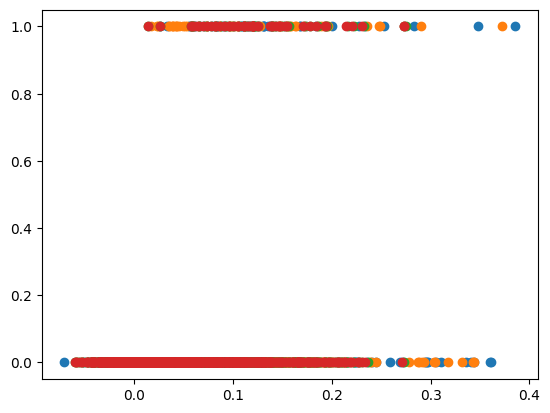

In [22]:
#Look at poly
r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain[poly_strat1], ytrain, Xtest[poly_strat1], ytest)
print("Polynomials")
showResults(r2, RMSE, yhat, ytest)
three = "Linear Regression with Polynomials"
r2_3 = r2
RMSE_3 = RMSE

#just interaction vars
r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain[interactions_strat1], ytrain, Xtest[interactions_strat1], ytest)
print("Polynomials - Just interaction variables")
showResults(r2, RMSE, yhat, ytest)

#cats and numerics
r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain[num_cat], ytrain, Xtest[num_cat], ytest)
print("Scaled Numerics and Categoricals")
showResults(r2, RMSE, yhat, ytest)

Xtest_r_num_cat = pd.concat([Xtest_num_r[numerics_strat1].reset_index(drop=True), Xtest[cats_strat1].reset_index(drop=True)],axis=1)
Xtrain_r_num_cat = pd.concat([Xtrain_num_r[numerics_strat1].reset_index(drop=True), Xtrain[cats_strat1].reset_index(drop=True)],axis=1)
r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain_r_num_cat, ytrain, Xtest_r_num_cat, ytest)
print("Unscaled Numerics and Categoricals")
showResults(r2, RMSE, yhat, ytest)

All Variables (Scaled Nums)
R2:  0.06038951880173271
RMSE:  0.20899683769128746

All Variables (Unscaled Nums)
R2:  0.08602263314128256
RMSE:  0.20612634820046885



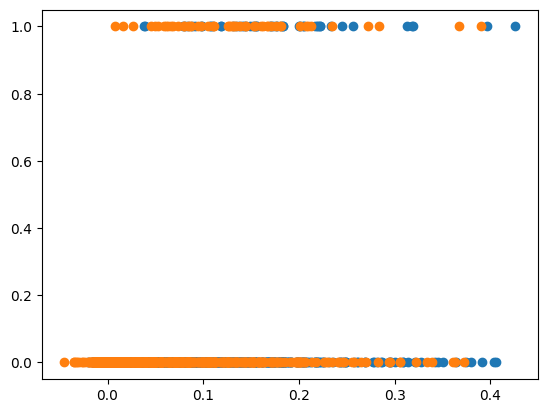

In [23]:
#all vars
r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain, ytrain, Xtest, ytest)
print("All Variables (Scaled Nums)")
showResults(r2, RMSE, yhat, ytest)

Xtest_r_all = pd.concat([Xtest_num_r[numerics_strat1].reset_index(drop=True), Xtest[poly_strat1].reset_index(drop=True), Xtest[cats_strat1].reset_index(drop=True)],axis=1)
Xtrain_r_all = pd.concat([Xtrain_num_r[numerics_strat1].reset_index(drop=True), Xtrain[poly_strat1].reset_index(drop=True), Xtrain[cats_strat1].reset_index(drop=True)],axis=1)
r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain_r_all, ytrain, Xtest_r_all, ytest)
print("All Variables (Unscaled Nums)")
showResults(r2, RMSE, yhat, ytest)
four = "Linear Regression with All Variables (Unscaled Nums)"
r2_4 = r2
RMSE_4 = RMSE

When the scaled numerics were used, it got better: Uping the degree to see how that effects the results

In [24]:
#loading the cleaned data from the data cleaning file, Project2EDA.ipynb
test_3 = pd.read_csv('./cleaned_data/c_test_deg3.csv')
train_3 = pd.read_csv('./cleaned_data/c_train_deg3.csv')

# Dropping row number
test_3 = test_3.drop(columns=['Unnamed: 0'])
train_3 = train_3.drop(columns=['Unnamed: 0'])

#seperate into X and y
ytest_3 = test_3['stroke']
ytrain_3 = train_3['stroke']
Xtest_3 = test_3.drop(columns='stroke')
Xtrain_3 = train_3.drop(columns='stroke')

Xtest_3.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'log_glucose', 'gender_Female', 'gender_Male', 'ever_married_No',
       'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'residence_type_Rural', 'residence_type_Urban',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'log_glucose.1',
       'gender_Female.1', 'gender_Male.1', 'ever_married_No.1',
       'ever_married_Yes.1', 'work_type_Govt_job.1',
       'work_type_Never_worked.1', 'work_type_Private.1',
       'work_type_Self-employed.1', 'work_type_children.1',
       'residence_type_Rural.1', 'residence_type_Urban.1',
       'smoking_status_Unknown.1', 'smoking_status_formerly smoked.1',
       'smoking_status_never smoked.1', 'smoking_status_smokes.1', 'age^2',
       'age hypertension', 'age heart_disease', 'age avg_

Scaled Numerics and Polynomials - with Degree 3
R2:  0.07223098325728117
RMSE:  0.20767571821148853



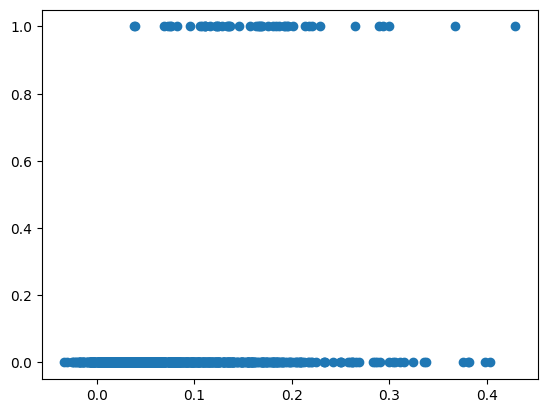

In [25]:
#nums and poly
Xtrain_3_np = Xtrain_3.loc[:,['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi','age^2', 'age hypertension','age heart_disease', 'age avg_glucose_level', 'age bmi','hypertension^2', 'hypertension heart_disease','hypertension avg_glucose_level', 'hypertension bmi', 'heart_disease^2','heart_disease avg_glucose_level', 'heart_disease bmi','avg_glucose_level^2', 'avg_glucose_level bmi', 'bmi^2'] ]
Xtest_3_np = Xtest_3.loc[:,['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi','age^2', 'age hypertension','age heart_disease', 'age avg_glucose_level', 'age bmi','hypertension^2', 'hypertension heart_disease','hypertension avg_glucose_level', 'hypertension bmi', 'heart_disease^2','heart_disease avg_glucose_level', 'heart_disease bmi','avg_glucose_level^2', 'avg_glucose_level bmi', 'bmi^2'] ]

r2, yhat, residuals, SSE, RMSE = linear_reg_model(Xtrain_3_np, ytrain_3, Xtest_3_np, ytest_3)
print("Scaled Numerics and Polynomials - with Degree 3")
showResults(r2, RMSE, yhat, ytest)

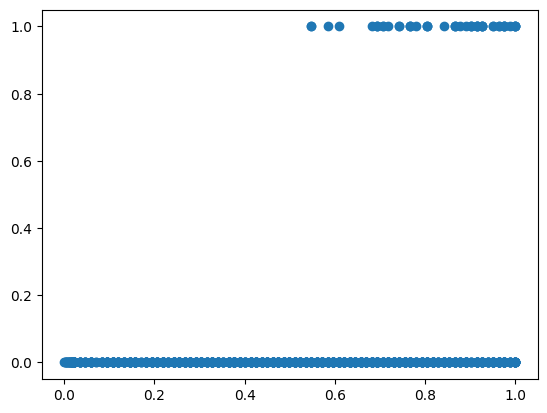

In [26]:
plt.scatter(Xtest['age'], ytest)

Logit Regression - Strategy 2

Used since the target variable is a binary 0/1
This can also be used to create a table that gives a probability each case will have a stroke given the training data

In [27]:
#set up for Logit Regression
#source: https://realpython.com/logistic-regression-python/
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from statistics import mean

def logit_reg(Xtrain, ytrain, Xtest, ytest):
    model = LogisticRegression(solver='liblinear', random_state=2).fit(Xtrain, ytrain)
    yhat = model.predict(Xtest)
    yprob = model.predict_proba(Xtest)
    
    #data = [ytest, yhat, yprob[:, 0], yprob[:, 1]]
    #df = pd.DataFrame(data, columns=['Result', 'Prediction', 'Probability of 0', 'Probability of 1']) 
    #df = pd.concat([ytest, yhat, yprob[]], axis=1)
    #data = [ytest, yhat]
    #df = pd.DataFrame(data, columns=['Result', 'Prediction'])
    yt =pd.DataFrame({'Result':ytest})
    yh = pd.DataFrame({'Prediction':yhat})
    yp =pd.DataFrame(yprob, columns=['Probability of 0', 'Probability of 1'])
    df = pd.concat([yt.reset_index(drop=True), yh.reset_index(drop=True), yp.reset_index(drop=True)], axis=1)
    
    #using probability to calculate a sort-of R2
    #calc Sum of Squared Error (SSE)
    SSE = np.sum(np.square(ytest - yp['Probability of 1']))
    N_test = len(ytest)
    
    # Total Sum of Squares (TSS)
    avg = mean(ytest)
    TSS = 0
    for i in ytest:
        TSS += ((i-avg)**2)
    
    #r2 = 1 - (SSE/TSS)
    r2 = 1 - (SSE/TSS)
    

    conM_array = confusion_matrix(ytest, model.predict(Xtest))
    residuals = ytest - yhat
    N_test = len(ytest)
    RMSE = (SSE/N_test)**(1/2)
    return r2, yhat, residuals, SSE, RMSE, conM_array, df
    
def showResults_log(r2, RMSE, y_hat, y_test, conM_array):
    print("R2: ", r2)
    print("RMSE: ", RMSE)
    print("Confustion Matrix ", conM_array)
    print(plt.scatter(y_hat, y_test), "\n")


Scaled age
R2:  0.08785626864336804
RMSE:  0.20591947746073525
Confustion Matrix  [[973   0]
 [ 50   0]]

unscaled age
R2:  0.09086800700673126
RMSE:  0.2055792414083986
Confustion Matrix  [[973   0]
 [ 50   0]]



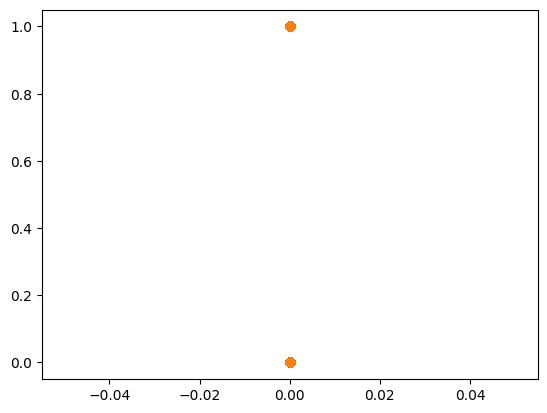

In [28]:
#with age - very likely underfit but interesting

print("Scaled age")
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain['age'].values.reshape(-1,1), ytrain, Xtest['age'].values.reshape(-1,1), ytest)
showResults_log(r2, RMSE, yhat, ytest, conM_array)
five = "Logistic Regression with Scaled Age"
r2_5 = r2
RMSE_5 = RMSE

print("unscaled age")
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain_num_r['age'].values.reshape(-1,1), ytrain, Xtest_num_r['age'].values.reshape(-1,1), ytest)
showResults_log(r2, RMSE, yhat, ytest, conM_array)
six = "Logistic Regression with Scaled Age"
r2_6 = r2
RMSE_6 = RMSE

Scaled Numerics
R2:  0.0870967252481577
RMSE:  0.20600519434262732
Confustion Matrix  [[973   0]
 [ 50   0]]

Unscaled Numerics
R2:  0.09086897397894544
RMSE:  0.20557913207913253
Confustion Matrix  [[973   0]
 [ 50   0]]

Scaled Numerics and Polynomials
R2:  0.07655322900625461
RMSE:  0.20719139863948877
Confustion Matrix  [[970   3]
 [ 48   2]]

Unscaled Numerics and Polynomials
R2:  0.05768580151014058
RMSE:  0.2092973145722793
Confustion Matrix  [[966   7]
 [ 47   3]]

Categoricals
R2:  0.020721300725050518
RMSE:  0.21336291819434425
Confustion Matrix  [[973   0]
 [ 50   0]]



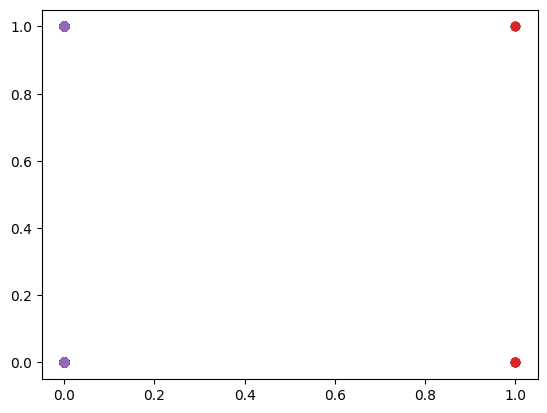

In [29]:
#look at just the selected numerics
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain[numerics_strat1], ytrain, Xtest[numerics_strat1], ytest)
print("Scaled Numerics")
showResults_log(r2, RMSE, yhat, ytest, conM_array)
seven = "Logistic Regression with Scaled Numerics"
r2_7 = r2
RMSE_7 = RMSE

r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain_num_r[numerics_strat1], ytrain, Xtest_num_r[numerics_strat1], ytest)
print("Unscaled Numerics")
showResults_log(r2, RMSE, yhat, ytest, conM_array)
eight = "Logistic Regression with Unscaled Numerics"
r2_8 = r2
RMSE_8 = RMSE
df_res = df

#look at both numerics and poly
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain[num_poly_strat1], ytrain, Xtest[num_poly_strat1], ytest)
print("Scaled Numerics and Polynomials")
showResults_log(r2, RMSE, yhat, ytest, conM_array)

Xtest_r_num_poly = pd.concat([Xtest_num_r[numerics_strat1].reset_index(drop=True), Xtest[poly_strat1].reset_index(drop=True)],axis=1)
Xtrain_r_num_poly = pd.concat([Xtrain_num_r[numerics_strat1].reset_index(drop=True), Xtrain[poly_strat1].reset_index(drop=True)],axis=1)
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain_r_num_poly, ytrain, Xtest_r_num_poly, ytest)
print("Unscaled Numerics and Polynomials")
showResults_log(r2, RMSE, yhat, ytest, conM_array)

#look at cats
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain[cats_strat1], ytrain, Xtest[cats_strat1], ytest)
print("Categoricals")
showResults_log(r2, RMSE, yhat, ytest, conM_array)

Polynomials
R2:  0.07838270511732703
RMSE:  0.20698605944136494
Confustion Matrix  [[972   1]
 [ 49   1]]

Polynomials - Just interaction variables
R2:  0.06101186606694575
RMSE:  0.2089276121144549
Confustion Matrix  [[973   0]
 [ 49   1]]

Scaled Numerics and Categoricals
R2:  0.08730492804308176
RMSE:  0.20598170154542209
Confustion Matrix  [[973   0]
 [ 50   0]]

Unscaled Numerics and Categoricals
R2:  0.0899820294354865
RMSE:  0.20567938871653077
Confustion Matrix  [[973   0]
 [ 50   0]]



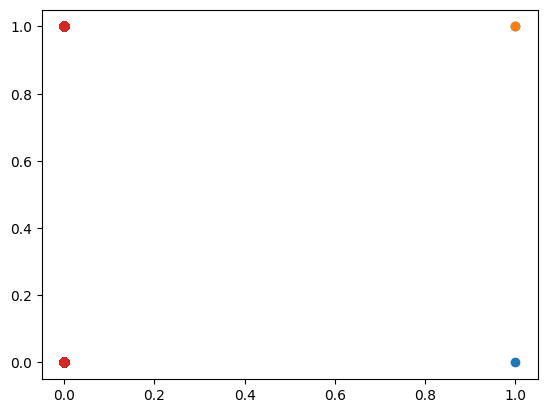

In [30]:
#Look at poly
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain[poly_strat1], ytrain, Xtest[poly_strat1], ytest)
print("Polynomials")
showResults_log(r2, RMSE, yhat, ytest, conM_array)

#just interaction vars
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain[interactions_strat1], ytrain, Xtest[interactions_strat1], ytest)
print("Polynomials - Just interaction variables")
showResults_log(r2, RMSE, yhat, ytest, conM_array)

#cats and numerics
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain[num_cat], ytrain, Xtest[num_cat], ytest)
print("Scaled Numerics and Categoricals")
showResults_log(r2, RMSE, yhat, ytest, conM_array)
nine = "Logistic Regression with Scaled Numerics and Categoricals"
r2_9 = r2
RMSE_9 = RMSE

Xtest_r_num_cat = pd.concat([Xtest_num_r[numerics_strat1].reset_index(drop=True), Xtest[cats_strat1].reset_index(drop=True)],axis=1)
Xtrain_r_num_cat = pd.concat([Xtrain_num_r[numerics_strat1].reset_index(drop=True), Xtrain[cats_strat1].reset_index(drop=True)],axis=1)
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain_r_num_cat, ytrain, Xtest_r_num_cat, ytest)
print("Unscaled Numerics and Categoricals")
showResults_log(r2, RMSE, yhat, ytest, conM_array)
ten = "Logistic Regression with Unscaled Numerics and Categoricals"
r2_10 = r2
RMSE_10 = RMSE

All Variables (Scaled Nums)
R2:  0.08172679698384255
RMSE:  0.20661019332087274
Confustion Matrix  [[973   0]
 [ 49   1]]

All Variabled (Unscaled Nums)
R2:  0.05779064993931016
RMSE:  0.20928567031118478
Confustion Matrix  [[966   7]
 [ 47   3]]



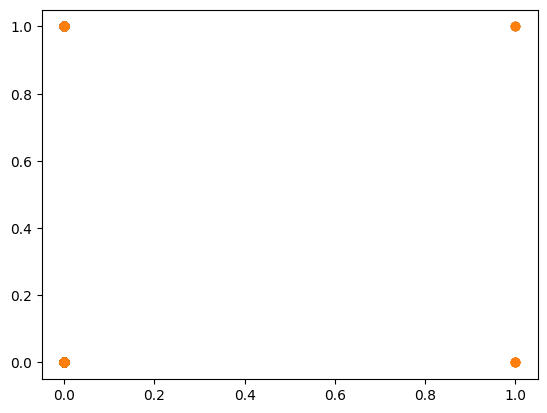

In [31]:
#all vars
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain, ytrain, Xtest, ytest)
print("All Variables (Scaled Nums)")
showResults_log(r2, RMSE, yhat, ytest, conM_array)
eleven = "Logistic Regression with All Variables (Scaled Nums)"
r2_11 = r2
RMSE_11 = RMSE

Xtest_r_all = pd.concat([Xtest_num_r[numerics_strat1].reset_index(drop=True), Xtest[poly_strat1].reset_index(drop=True), Xtest[cats_strat1].reset_index(drop=True)],axis=1)
Xtrain_r_all = pd.concat([Xtrain_num_r[numerics_strat1].reset_index(drop=True), Xtrain[poly_strat1].reset_index(drop=True), Xtrain[cats_strat1].reset_index(drop=True)],axis=1)
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain_r_all, ytrain, Xtest_r_all, ytest)
print("All Variabled (Unscaled Nums)")
showResults_log(r2, RMSE, yhat, ytest, conM_array)
tweleve = "Logistic Regression with All Variables (Scaled Nums)"
r2_12 = r2
RMSE_12 = RMSE

Scaled Numerics and Polynomials - with Degree 3
R2:  0.07432414462921999
RMSE:  0.2074413149042534
Confustion Matrix  [[973   0]
 [ 50   0]]



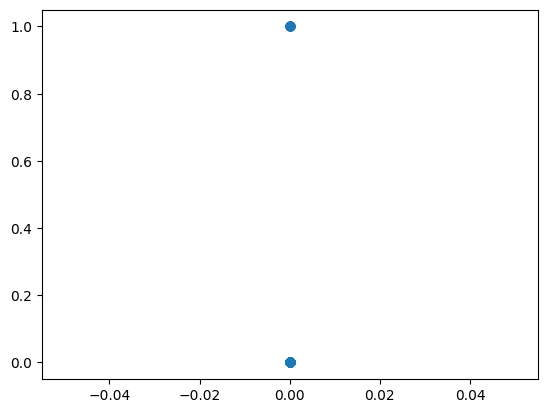

In [32]:
#expanded version
r2, yhat, res, SSE, RMSE, conM_array, df = logit_reg(Xtrain_3_np, ytrain_3, Xtest_3_np, ytest_3)
print("Scaled Numerics and Polynomials - with Degree 3")
showResults_log(r2, RMSE, yhat, ytest, conM_array)

Results table with any model that was decent

In [33]:
table = {
    'Test': [one, two, three, four, five, six, seven, eight, nine, ten, eleven, tweleve],
    'R^2': [r2_1, r2_2, r2_3, r2_4, r2_5, r2_6, r2_7, r2_8, r2_9, r2_10, r2_11, r2_12],
    'RMSE': [RMSE_1, RMSE_2, RMSE_3, RMSE_4, RMSE_5, RMSE_6, RMSE_7, RMSE_8, RMSE_9, RMSE_10, RMSE_11, RMSE_12],
    }

df = pd.DataFrame(table)

df

,Test,R^2,RMSE
0,Linear Regression with Scaled Numerics and Pol...,0.087109,0.206004
1,Linear Regression with Unscaled Numerics and P...,0.087048,0.206011
2,Linear Regression with Polynomials,0.082406,0.206534
3,Linear Regression with All Variables (Unscaled...,0.086023,0.206126
4,Logistic Regression with Scaled Age,0.087856,0.205919
5,Logistic Regression with Scaled Age,0.090868,0.205579
6,Logistic Regression with Scaled Numerics,0.087097,0.206005
7,Logistic Regression with Unscaled Numerics,0.090869,0.205579
8,Logistic Regression with Scaled Numerics and C...,0.087305,0.205982
9,Logistic Regression with Unscaled Numerics and...,0.089982,0.205679


Based on the results the model with the best fit was done with Logistic Regression and Scaled Numerics

It is interesting to see the difference between using scaled vs. unscaled varaibles. In some cases using unscaled variables would make the model fit better, but not all. It is possible using unscaled variables put more emphasis on age, the variable with the most correlation to stroke, and resulted in a (usually) better fitting model. 

The most interesting result is the probability of having a stroke for each case created in Logisitic Regression. While cases that did have a stroke often did not exceed 50% chance, they did have a higher chance. This proves that the data can be used to predict stroke, as if someone has, for example, above a 20% chance they know they are at extra risk.

## Decision Trees

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [35]:
# Create Training and Testing DataFrames

train = pd.read_csv('cleaned_data/c_train.csv')
test = pd.read_csv('cleaned_data/c_test.csv')

columns = train.columns
all_metrics = columns[1:-1]
no_poly = columns[1:23]
no_poly

# Create y values, and X values in with all metrics taken into account

X_train = train[all_metrics]
y_train = train['stroke']
X_test = test[all_metrics]
y_test = test['stroke']

# Create X values for only original metrics, not metrics from polynomial expansion

X_train_np = train[no_poly]
X_test_np = test[no_poly]

columns
cat2 = columns[7:23].to_list()
cat = columns[2:4].to_list()
categories = cat + cat2

# Create X values for only categorical data, not linear data

X_train_cat = train[categories]
X_test_cat = test[categories]


In [36]:
# Create and test trees of different max depths for the whole data

all_r2 = []
all_rmse = []

for i in range(1,100):
  model = tree.DecisionTreeClassifier(max_depth=i)
  cart = model.fit(X_train, y_train)

  prediction = cart.predict(X_test)
  r2 = r2_score(y_test,prediction)
  RMSE = np.sqrt(mean_squared_error(y_test,prediction))
  all_r2.append(r2)
  all_rmse.append(RMSE)

print('Highest r2 value: ' + str(max(all_r2)))
print('Depth: ' + str(all_r2.index(max(all_r2)) + 1))
print('Lowest RMSE value: ' + str(min(all_rmse)))
print('Depth: ' + str(all_rmse.index(min(all_rmse)) + 1))

Highest r2 value: -0.05138746145940387
Depth: 1
Lowest RMSE value: 0.22107884414269094
Depth: 1


In [37]:
# Create and test trees of different max depths without the polynomials

poly_r2 = []
poly_rmse = []

for i in range(1,20):
  model = tree.DecisionTreeClassifier(max_depth=i)
  cart = model.fit(X_train_np, y_train)

  prediction = cart.predict(X_test_np)
  r2 = r2_score(y_test,prediction)
  RMSE = np.sqrt(mean_squared_error(y_test,prediction))
  poly_r2.append(r2)
  poly_rmse.append(RMSE)

print('Highest r2 value: ' + str(max(poly_r2)))
print('Depth: ' + str(poly_r2.index(max(poly_r2)) + 1))
print('Lowest RMSE value: ' + str(min(poly_rmse)))
print('Depth: ' + str(poly_rmse.index(min(poly_rmse)) + 1))

Highest r2 value: -0.05138746145940387
Depth: 1
Lowest RMSE value: 0.22107884414269094
Depth: 1


In [38]:
# Create and test trees of different max depths for only categorical data

cat_r2 = []
cat_rmse = []

for i in range(1,100):
  model = tree.DecisionTreeClassifier(max_depth=i)
  cart = model.fit(X_train_cat, y_train)

  prediction = cart.predict(X_test_cat)
  r2 = r2_score(y_test,prediction)
  RMSE = np.sqrt(mean_squared_error(y_test,prediction))
  cat_r2.append(r2)
  cat_rmse.append(RMSE)

print('Highest r2 value: ' + str(max(cat_r2)))
print('Depth: ' + str(cat_r2.index(max(cat_r2)) + 1))
print('Lowest RMSE value: ' + str(min(cat_rmse)))
print('Depth: ' + str(cat_rmse.index(min(cat_rmse)) + 1))

Highest r2 value: -0.03035971223021572
Depth: 4
Lowest RMSE value: 0.21885688981825285
Depth: 4


-0.03035971223021572
0.21885688981825285


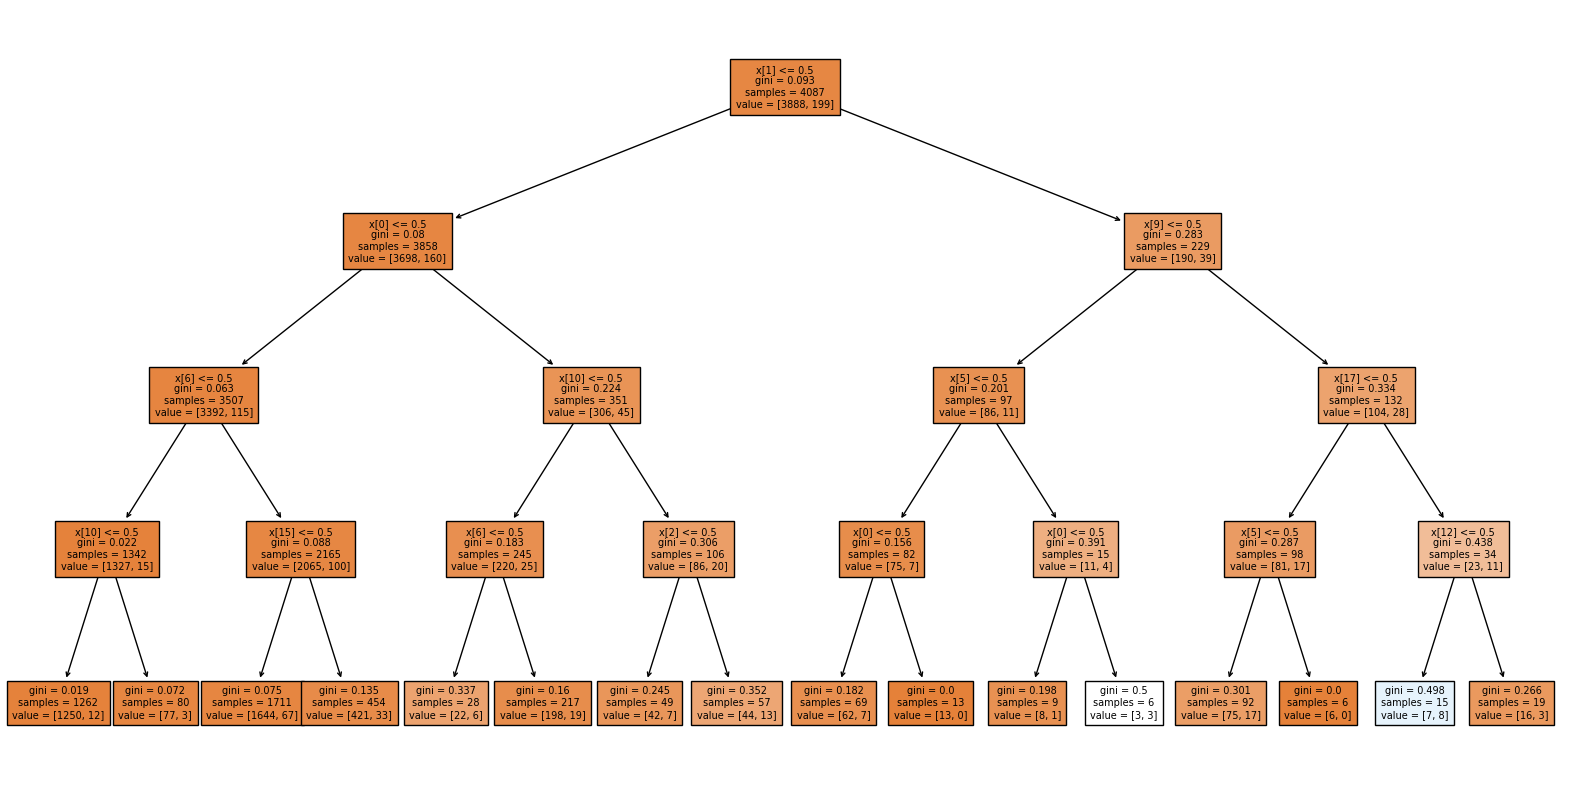

In [39]:
# Full model of only categorical variables, with max depth of 4
# This had the lowest RMSE and the highest r2

model = tree.DecisionTreeClassifier(max_depth=4)
cart = model.fit(X_train_cat,y_train)

prediction = cart.predict(X_test_cat)
r2 = r2_score(y_test,prediction)
RMSE = np.sqrt(mean_squared_error(y_test,prediction))

print(r2)
print(RMSE)

# Graph it

tree.plot_tree(model,filled=True,fontsize=7)
fig = plt.gcf()
fig.set_size_inches(20, 10)

## kNN

In [40]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

dftrain = pd.read_csv('./cleaned_data/c_train.csv')
dftest = pd.read_csv('./cleaned_data/c_test.csv')

In [41]:
X_test = dftest.drop(columns='stroke')
y_test = dftest['stroke']
X_train = dftrain.drop(columns='stroke')
y_train = dftrain['stroke']

In [42]:
# Renormalizing the data, as polynomials are not normalized
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

X_train = X_train.apply(maxmin)
X_test = X_test.apply(maxmin)

X_train = X_train.drop(columns=['gender_Other','Unnamed: 0'])
X_test = X_test.drop(columns=['gender_Other','Unnamed: 0'])

In [43]:
# Function to fit a kNN model and get R2 and RMSE
def RunKNN(k):
    model = KNeighborsClassifier(n_neighbors=k)
    fitted_model = model.fit(X_train,y_train)
    y_hat = fitted_model.predict(X_test) # Predict values for test set
    
    N_test = len(y_test)
    SSE = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
    TSS = np.sum( (y_test - y_test.mean())**2 )
    RMSE = (SSE/N_test)**(1/2)
    R2 = 1 - SSE/TSS
    return R2, RMSE

def plotR2s(R2s):
    plt.figure(figsize=(10,6))
    plt.plot(k_values,R2s,marker='o')
    plt.grid(True)
    plt.ylabel(f'$R^2$')
    plt.xlabel('k')
    plt.show()
    
def plotRMSEs(R2s):
    plt.figure(figsize=(10,6))
    plt.plot(k_values,RMSEs,marker='o')
    plt.grid(True)
    plt.ylabel(f'$RMSE$')
    plt.xlabel('k')
    plt.show()

In [44]:
X_test.head(5)

,age,hypertension,heart_disease,avg_glucose_level,bmi,log_glucose,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,hypertension^2,hypertension heart_disease,hypertension avg_glucose_level,hypertension bmi,heart_disease^2,heart_disease avg_glucose_level,heart_disease bmi,avg_glucose_level^2,avg_glucose_level bmi,bmi^2
0,0.706745,1.0,0.0,0.157026,0.519700,0.297625,0.0,1.0,0.0,1.0,...,1.0,0.0,0.333738,0.681739,0.0,0.0,0.0,0.070536,0.229240,0.345331
1,0.095797,0.0,0.0,0.267102,0.114447,0.445894,1.0,0.0,1.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.139194,0.104366,0.043649
2,0.853372,0.0,0.0,0.066199,0.457786,0.142611,1.0,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.025808,0.148335,0.284391
3,0.572336,0.0,0.0,0.747444,0.724203,0.857490,1.0,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.624101,0.823461,0.584677
4,0.902248,1.0,0.0,0.722913,0.808630,0.841795,1.0,0.0,0.0,1.0,...,1.0,0.0,0.780999,0.949565,0.0,0.0,0.0,0.592031,0.879396,0.700530


In [45]:
# Repeatedly run kNN on the model with different k to see how error changes
Nk = 50
k_values = np.arange(1, 1+Nk)

R2s = np.zeros(k_values.size)
RMSEs = np.zeros(k_values.size)

for k in k_values:
    R2s[k-1], RMSEs[k-1] = RunKNN(k)

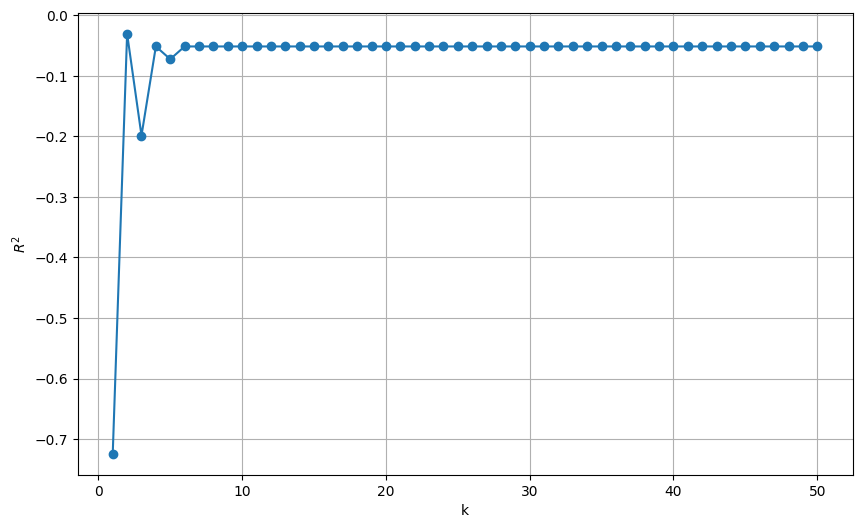

Best R2 for model: -0.03035971223021572


In [46]:
plotR2s(R2s)
print(f'Best R2 for model: {max(R2s)}')

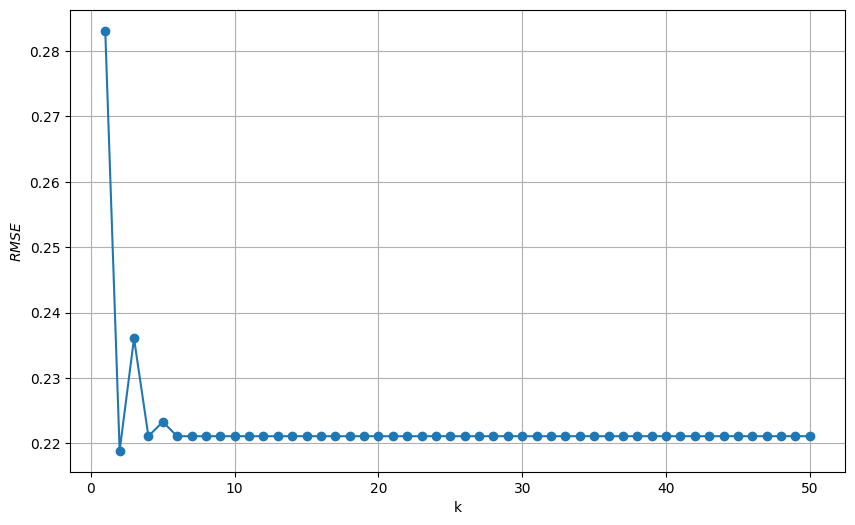

Best RMSE for model: 0.2831190610627407


In [47]:
plotRMSEs(RMSEs)
print(f'Best RMSE for model: {max(RMSEs)}')

Wow, all the $R^2$ are negative! That's bad! What about if we use less variables?

#### Running the model on less data

In [48]:
varlist = ['age','hypertension','heart_disease','log_glucose','ever_married_No','ever_married_Yes']

X_train = X_train[varlist]
X_test = X_test[varlist]

In [49]:
# Repeatedly run kNN on the model with different k to see how error changes
Nk = 50
k_values = np.arange(1, 1+Nk)

R2s = np.zeros(k_values.size)
RMSEs = np.zeros(k_values.size)

for k in k_values:
    R2s[k-1], RMSEs[k-1] = RunKNN(k)

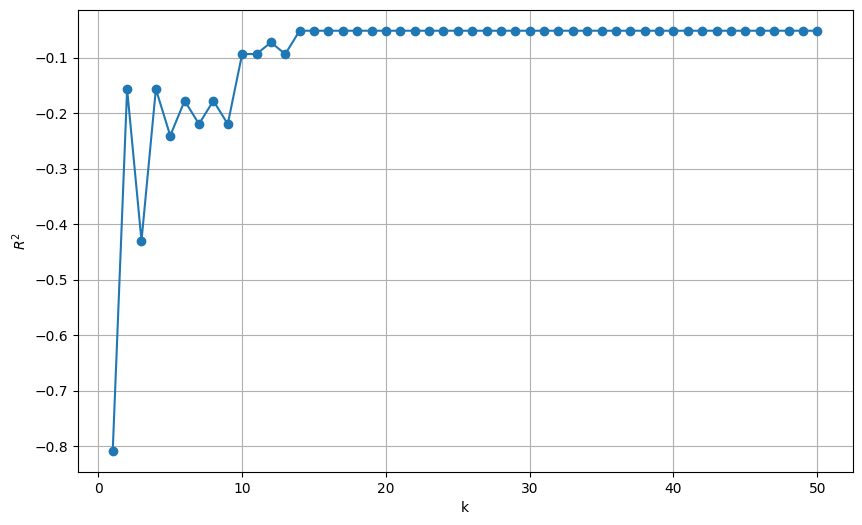

Best R2 for model: -0.05138746145940387


In [50]:
plotR2s(R2s)
print(f'Best R2 for model: {max(R2s)}')

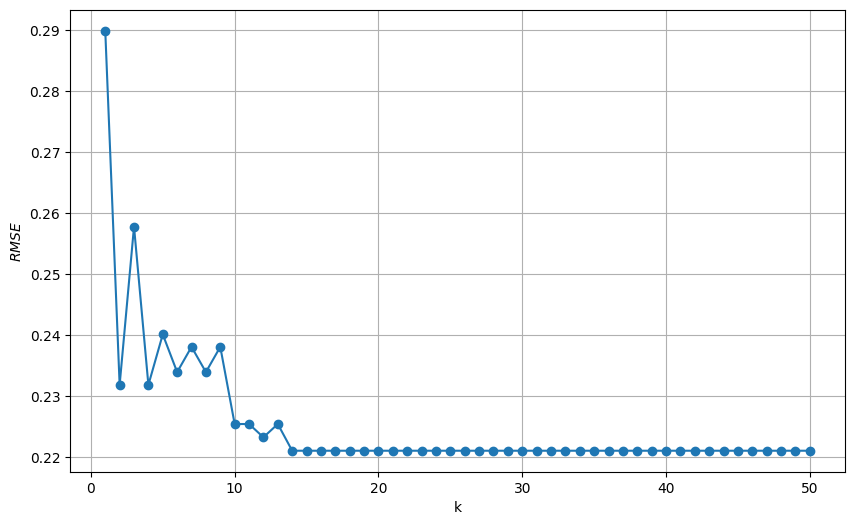

Best RMSE for model: 0.28994218589788784


In [51]:
plotRMSEs(RMSEs)
print(f'Best RMSE for model: {max(RMSEs)}')

Rats!

#### Running the model on only numeric data

In [52]:
dropcols = ['ever_married_No','ever_married_Yes']

X_train = X_train.drop(columns=dropcols)
X_test = X_test.drop(columns=dropcols)

In [53]:
# Repeatedly run kNN on the model with different k to see how error changes
Nk = 50
k_values = np.arange(1, 1+Nk)

R2s = np.zeros(k_values.size)
RMSEs = np.zeros(k_values.size)

for k in k_values:
    R2s[k-1], RMSEs[k-1] = RunKNN(k)

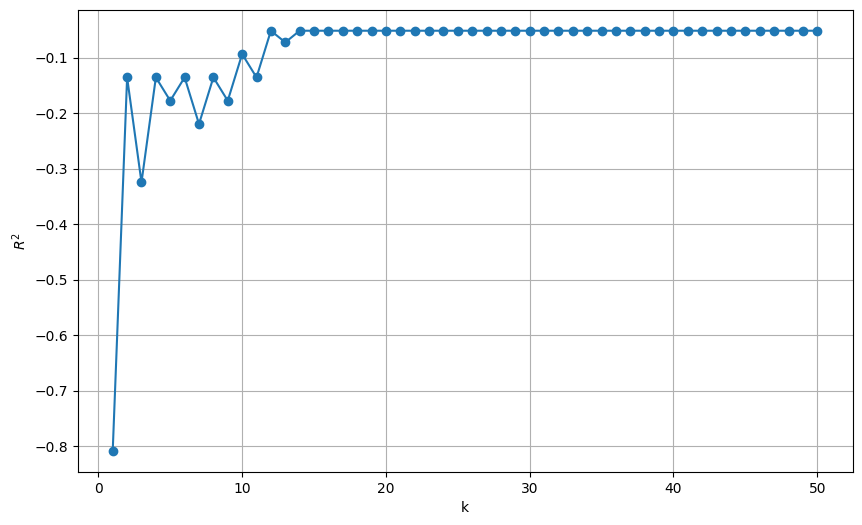

Best R2 for model: -0.05138746145940387


In [54]:
plotR2s(R2s)
print(f'Best R2 for model: {max(R2s)}')

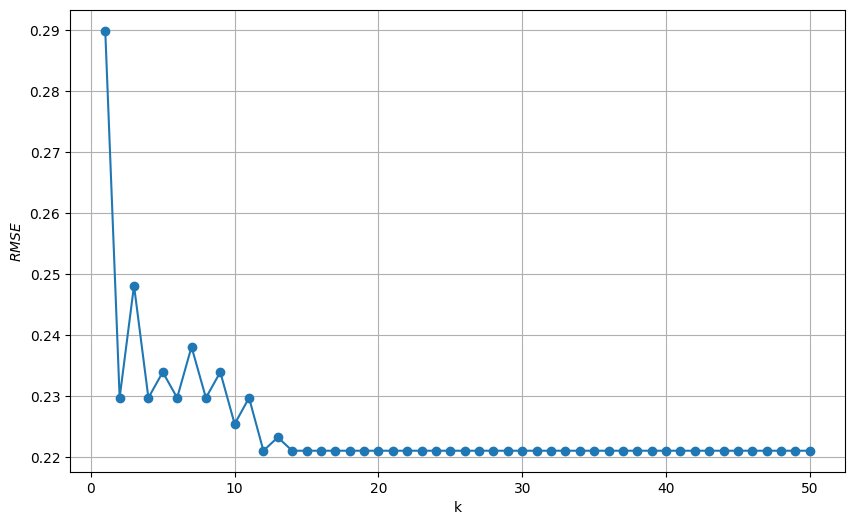

Best RMSE for model: 0.28994218589788784


In [55]:
plotRMSEs(RMSEs)
print(f'Best RMSE for model: {max(RMSEs)}')